## Background
The purpose of notebook is to see how categorical columns would be behave in Isolation Forests. A user may be concerned that high cardinality columns would be more frequently used than other columns

We would like to know:
1. Will they be splitting frequently or infrequently compared to other features? 
2. How would a high cardinality column behave? 
    - What if we use one-hot encoding? Would the behavior change?

In [1]:
import h2o
import pandas as pd
from h2o.estimators import H2OIsolationForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_231"; Java(TM) SE Runtime Environment (build 1.8.0_231-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from /Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/pf/w6ctt7r5639fbfclslj7nw2c0000gp/T/tmpqtc4_d0f
  JVM stdout: /var/folders/pf/w6ctt7r5639fbfclslj7nw2c0000gp/T/tmpqtc4_d0f/h2o_nmashayekhi_started_from_python.out
  JVM stderr: /var/folders/pf/w6ctt7r5639fbfclslj7nw2c0000gp/T/tmpqtc4_d0f/h2o_nmashayekhi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_nmashayekhi_3q3iyf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


## Import Data

In [2]:
train = h2o.import_file('train.csv')
test = h2o.import_file('test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
train.shape

(298, 12)

## Create a random Categorical Column

In [4]:
#Create new categorical column
nrows = len(train) #
l = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ncats = len(l)
newcol = l*(nrows//ncats) + l[:nrows%ncats]
train['CatCol'] = h2o.H2OFrame(newcol)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Create Model 1 - categorical column with 10 uniques

In [5]:
# Build an Isolation forest model
model1 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10)
model1.train(training_frame=train)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


## Set up functions to visualize trees

In [6]:
from h2o.tree import H2OTree
import subprocess
from IPython.display import Image

In [7]:
downloads_path = "/Users/nmashayekhi/Downloads"
mojo_file_name = downloads_path + "/my_gbm_mojo.zip"
h2o_jar_path= "/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/" + "backend/bin/h2o.jar"
mojo_full_path = mojo_file_name
gv_file_path = downloads_path + "/my_gbm_graph.gv"

image_file_name = downloads_path + "/my_gbm_tree"

In [8]:
#function to generate a GraphViz tree from the saved MOJO model
def generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_path, tree_id = 0):
    image_file_path = image_file_path + "_" + str(tree_id) + ".png"
    result = subprocess.call(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", 
                              str(tree_id), "-i", mojo_full_path , "-o", gv_file_path ], shell=False)
    result = subprocess.call(["ls",gv_file_path], shell = False)
    if result is 0:
        print("Success: Graphviz file " + gv_file_path + " is generated.")
    else: 
        print("Error: Graphviz file " + gv_file_path + " could not be generated.")

In [9]:
#function to generate the tree image as PNG from the saved GraphViz tree
def generateTreeImage(gv_file_path, image_file_path, tree_id):
    image_file_path = image_file_path + "_" + str(tree_id) + ".png"
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    if result is 0:
        print("Success: Image File " + image_file_path + " is generated.")
        print("Now you can execute the follow line as-it-is to see the tree graph:") 
        print("Image(filename='" + image_file_path + "\')")
    else:
        print("Error: Image file " + image_file_path + " could not be generated.")

## Visualize some of the trees of Model 1

In [10]:
model1.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


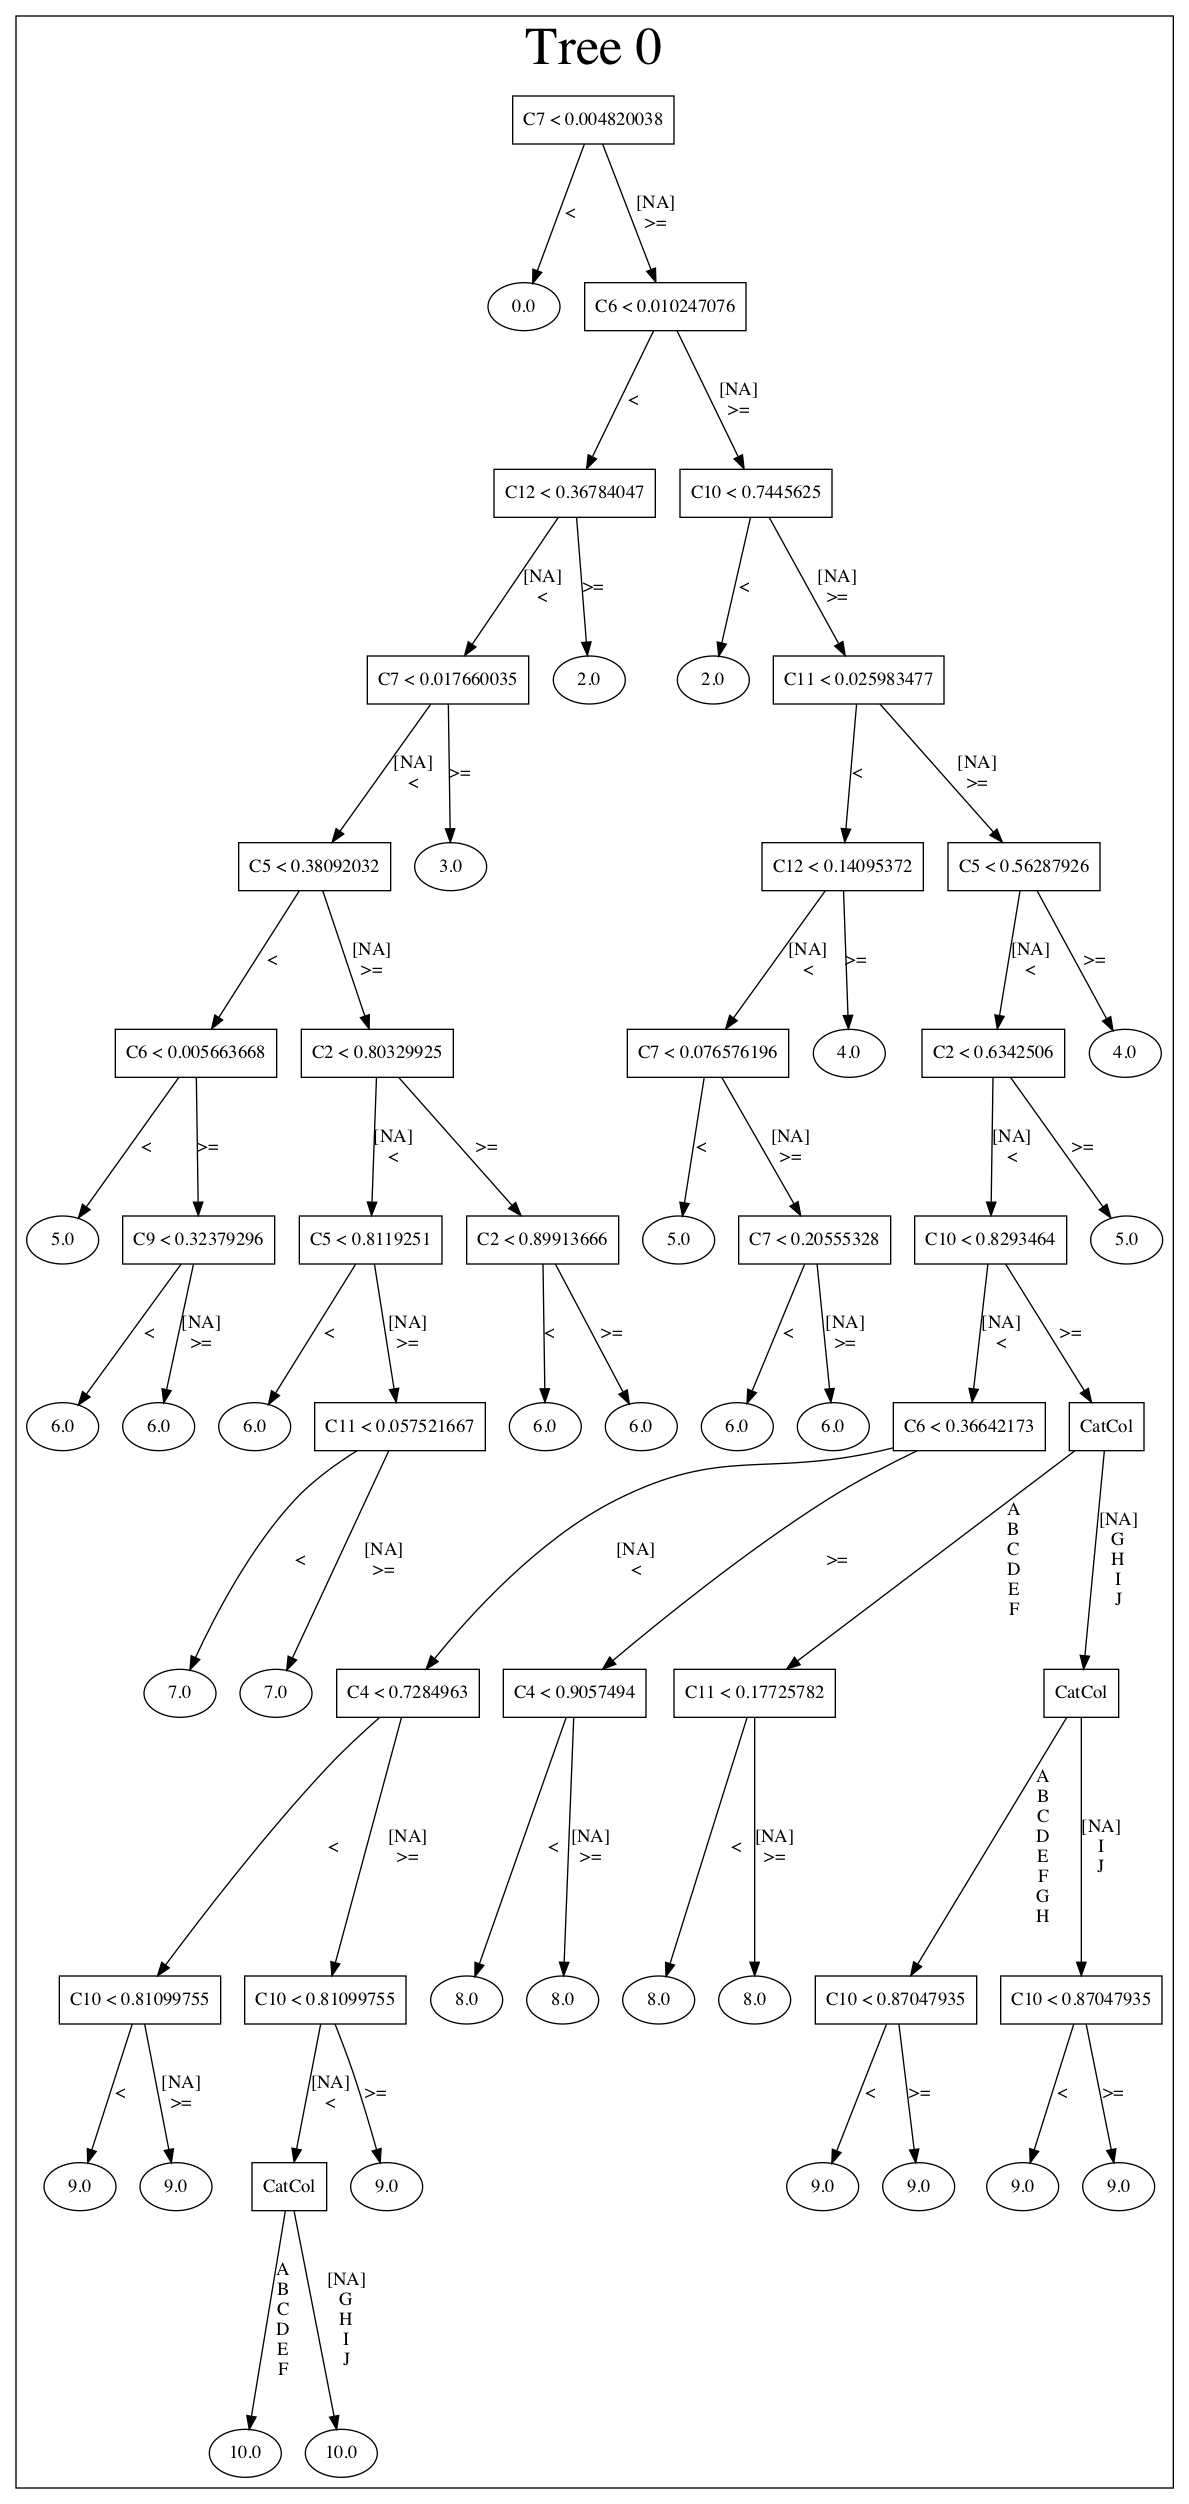

In [11]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_1.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_1.png')


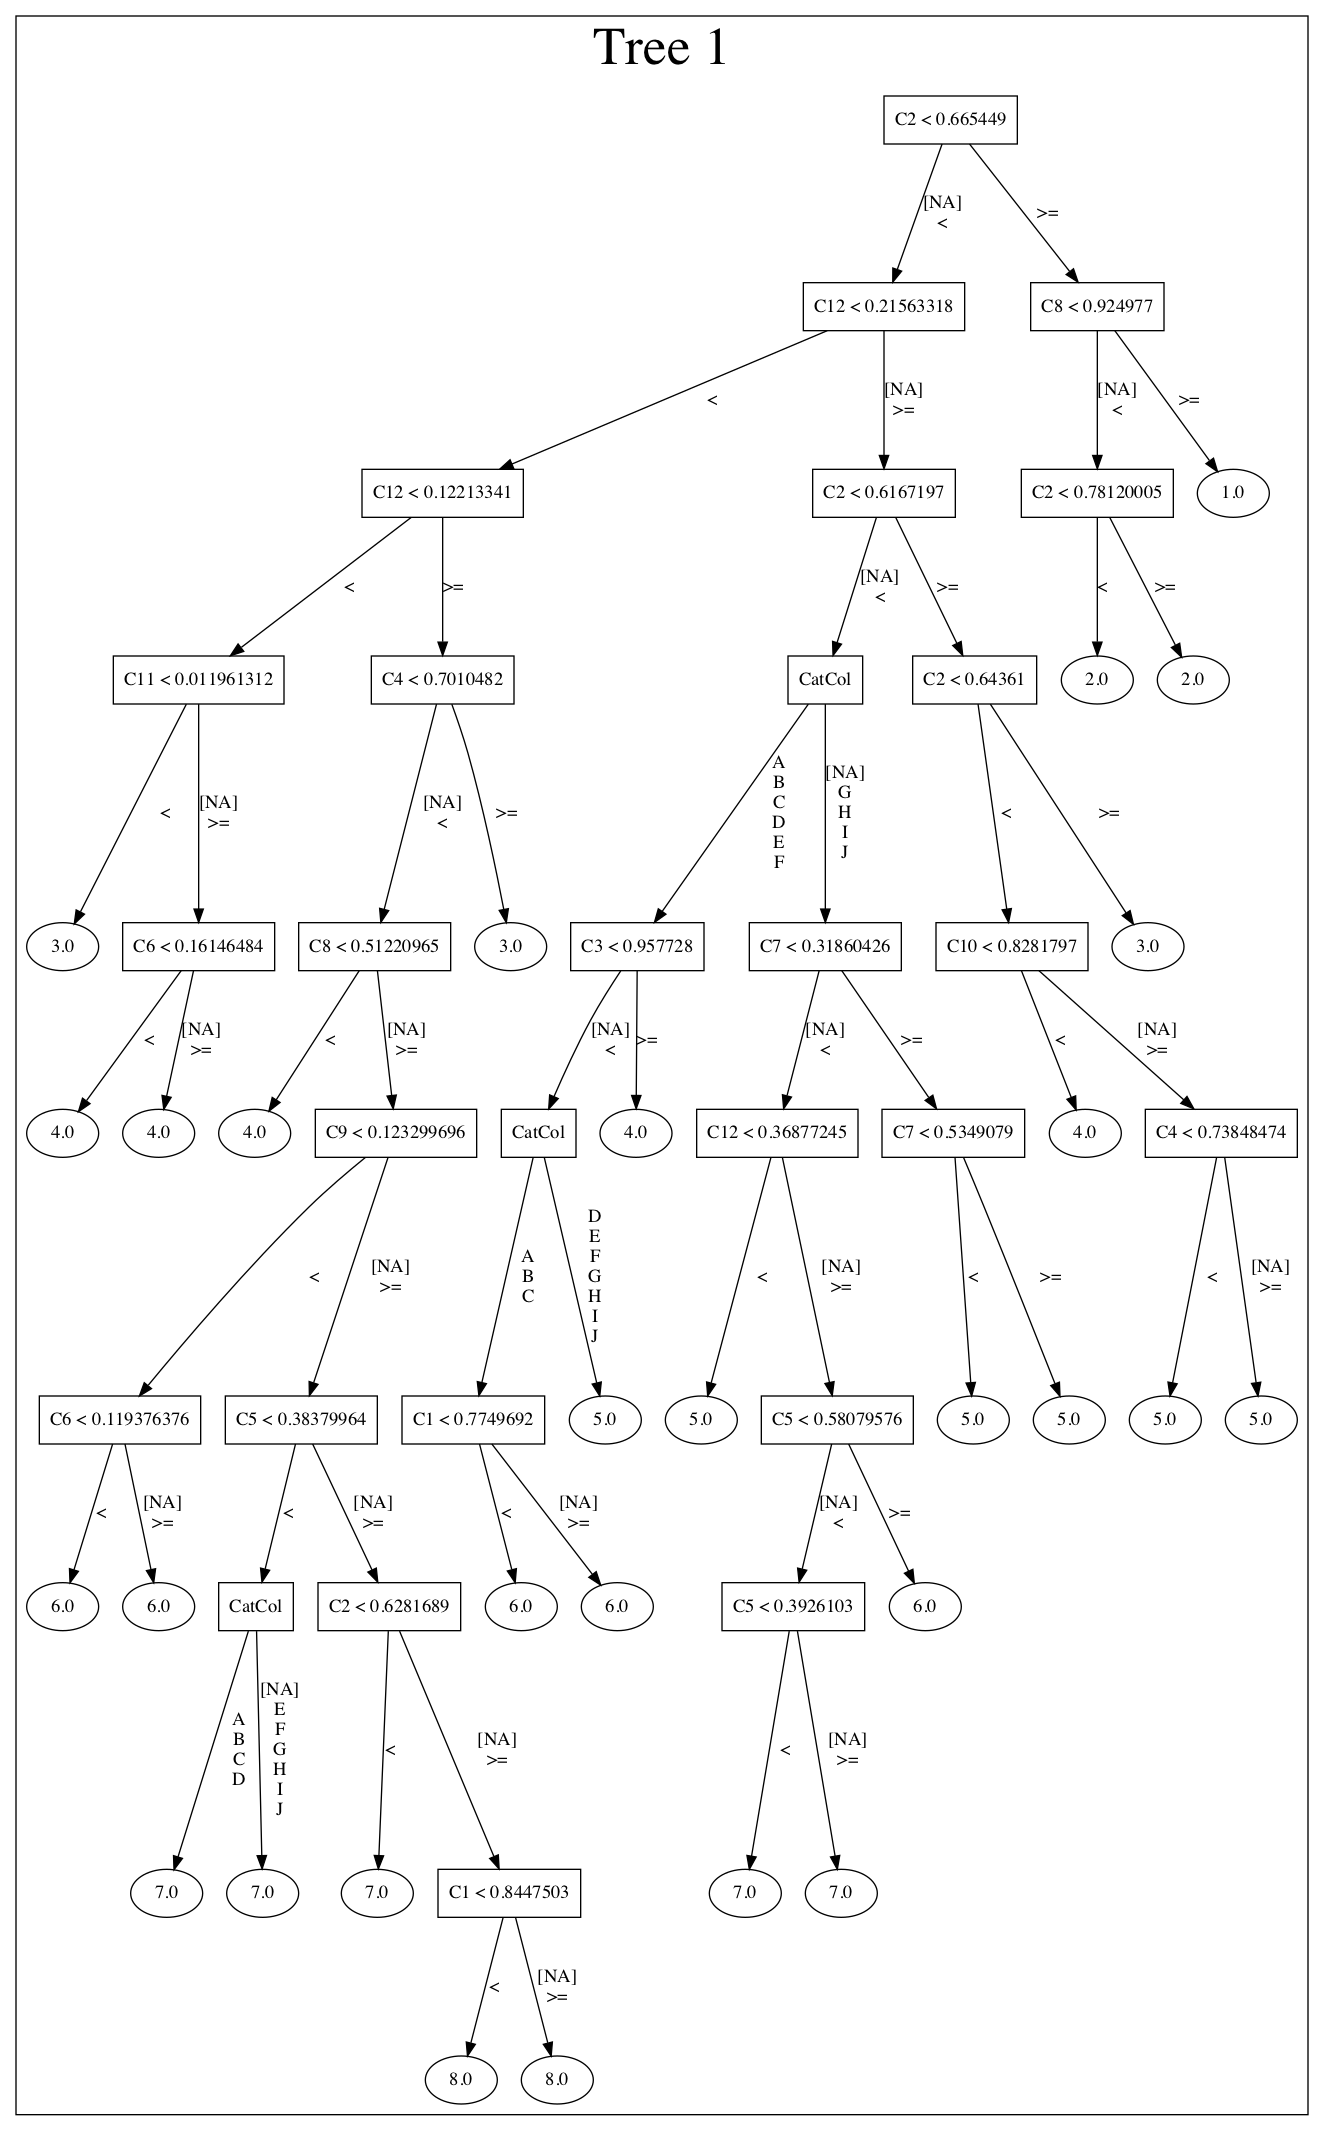

In [12]:
tree_num = 1
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

#### ^The categories remain in order [A, B, C, D, ...]

## Model 2 - Add another 'Unordered' Column

In [13]:
#Create new categorical column
nrows = len(train) #
l = ['A', '7', 'B', '6', 'C', '5', 'D', '4', 'E', '3', 'F', '2', 'G', '1', 'H', '0', 'I', '-1', 'J']
ncats = len(l)
newcol = l*(nrows//ncats) + l[:nrows%ncats]
train['CatCol_with_Num'] = h2o.H2OFrame(newcol)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [14]:
# Build an Isolation forest model
model2 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10)
model2.train(training_frame=train)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [15]:
model2.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


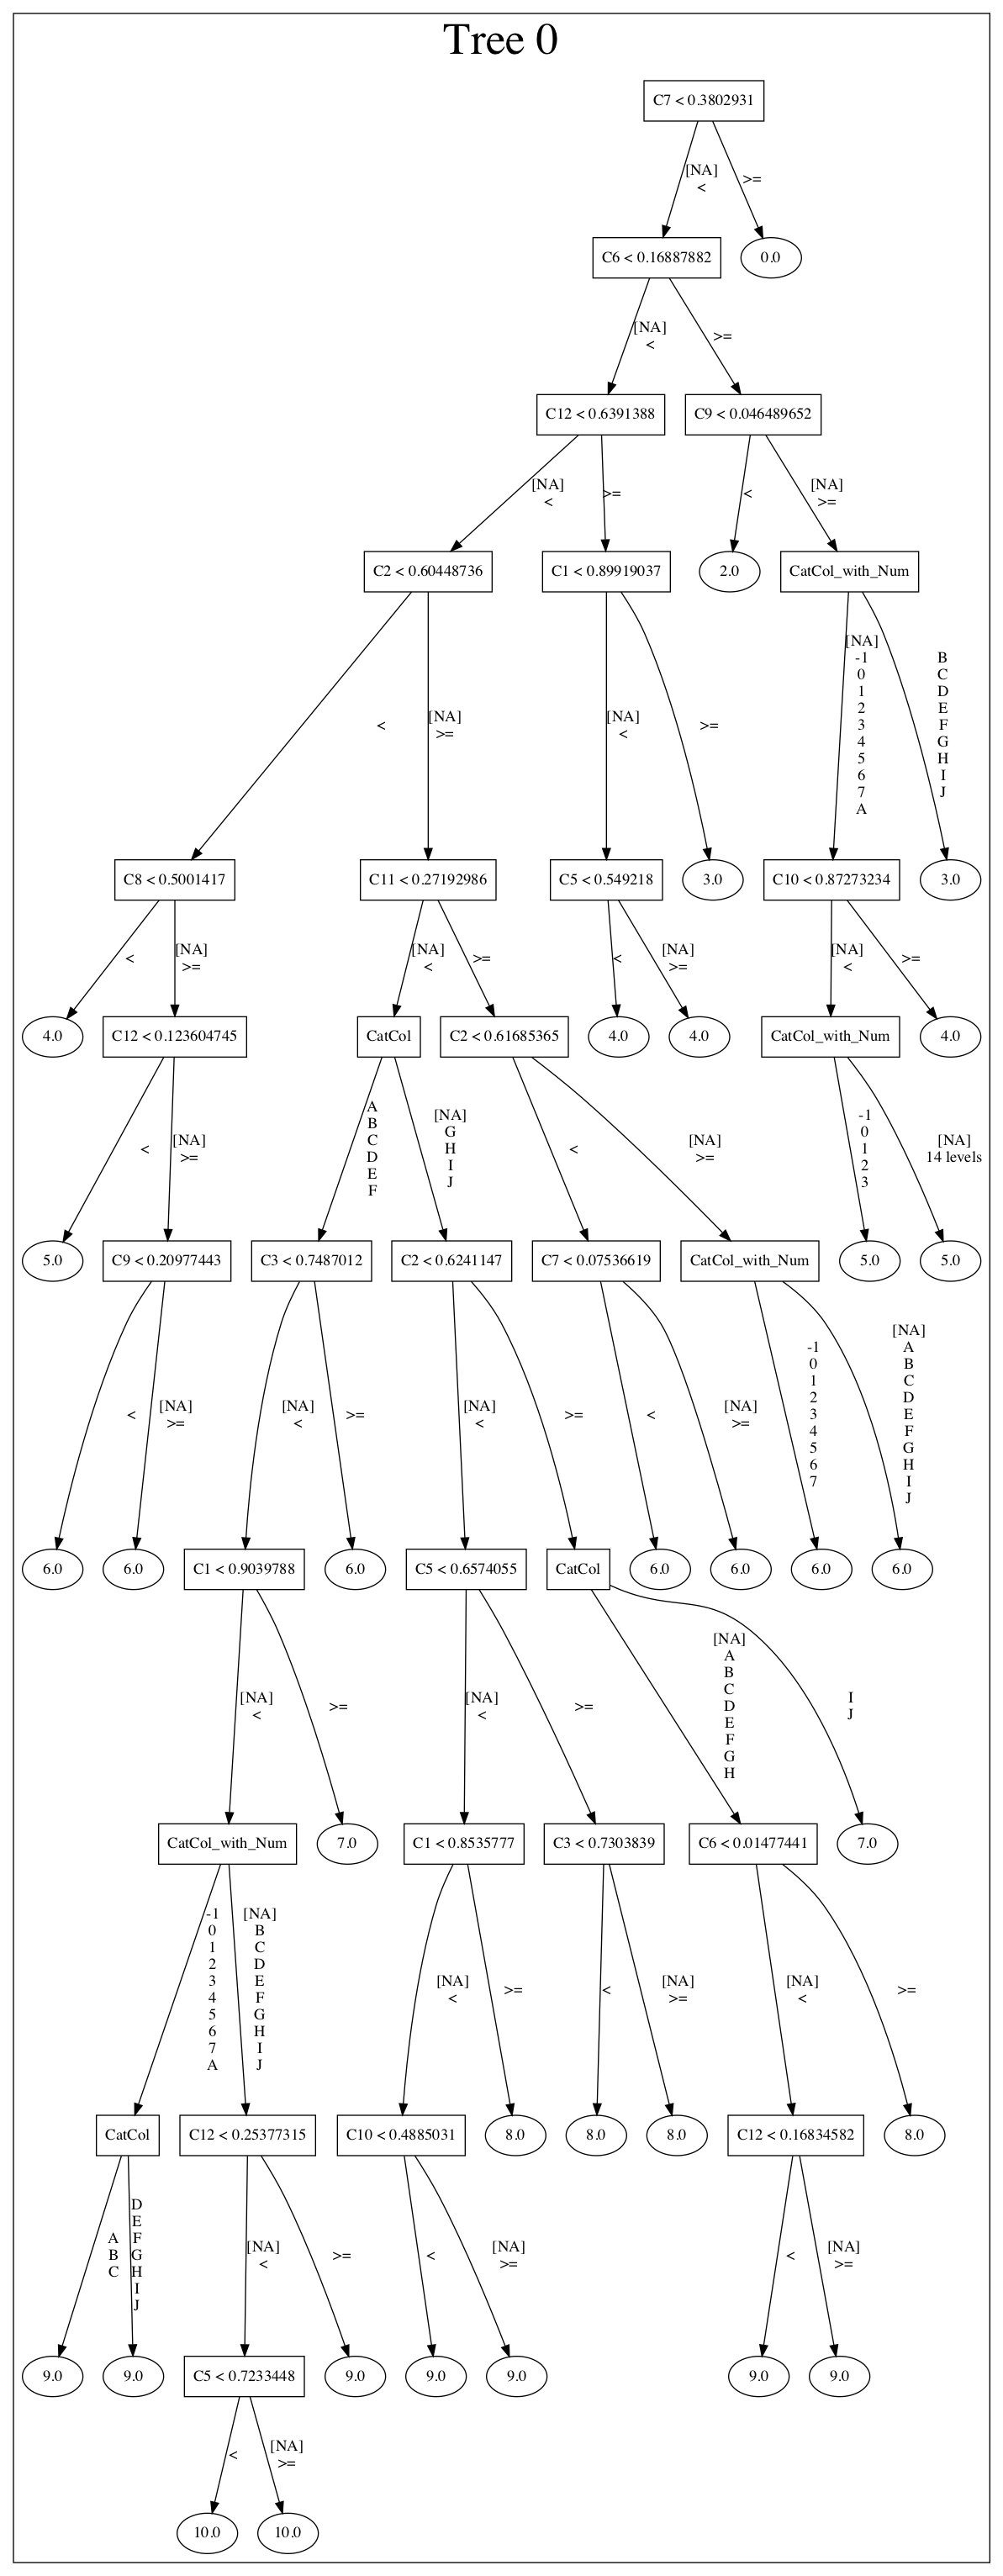

In [16]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

#### ^Categorical columns remain ordered

## Model 3 - extremely high cardinality
#### of unique categories = # of rows

In [17]:
#Create a copy of the original training data
train_max = h2o.deep_copy(train, 'train_max')
#Drop other cat columns
train_max = train_max.drop(['CatCol', 'CatCol_with_Num'])

#Create new categorical column
nrows = len(train) #
l = range(nrows)
train_max['CatCol_Max_Cardinality'] = h2o.H2OFrame(list(l))
train_max['CatCol_Max_Cardinality'] = train_max['CatCol_Max_Cardinality'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
# Build an Isolation forest model
model3 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10)
model3.train(training_frame=train_max)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [19]:
model3.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


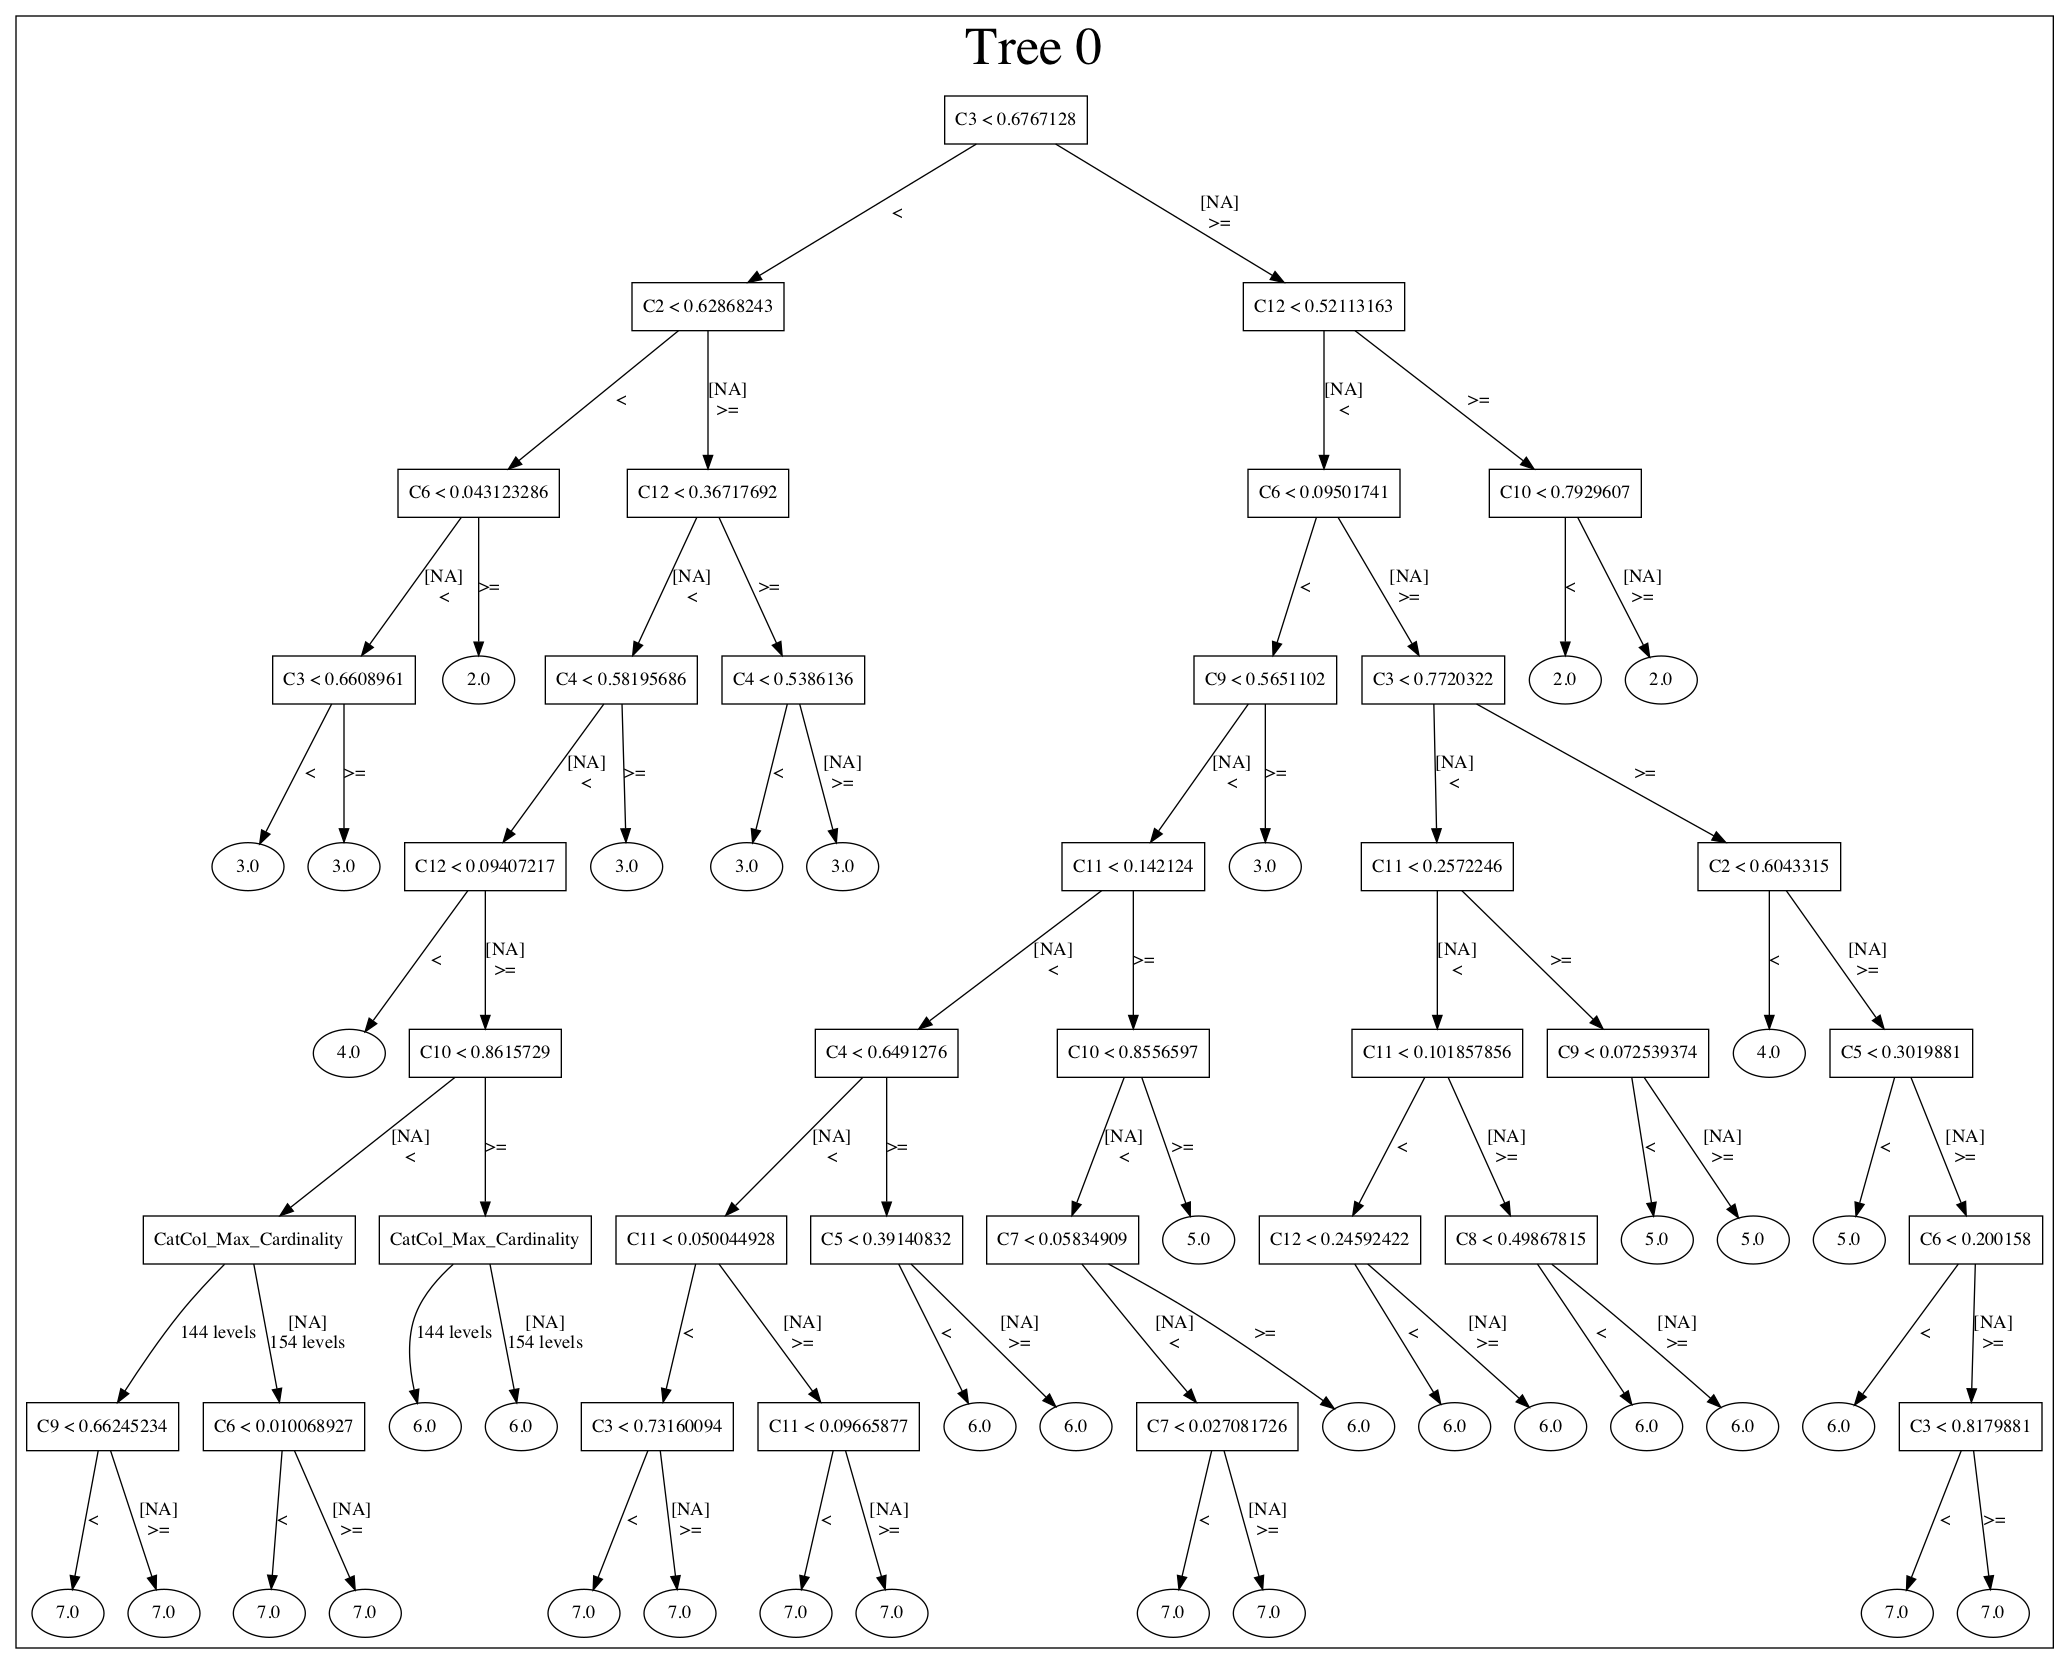

In [20]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_1.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_1.png')


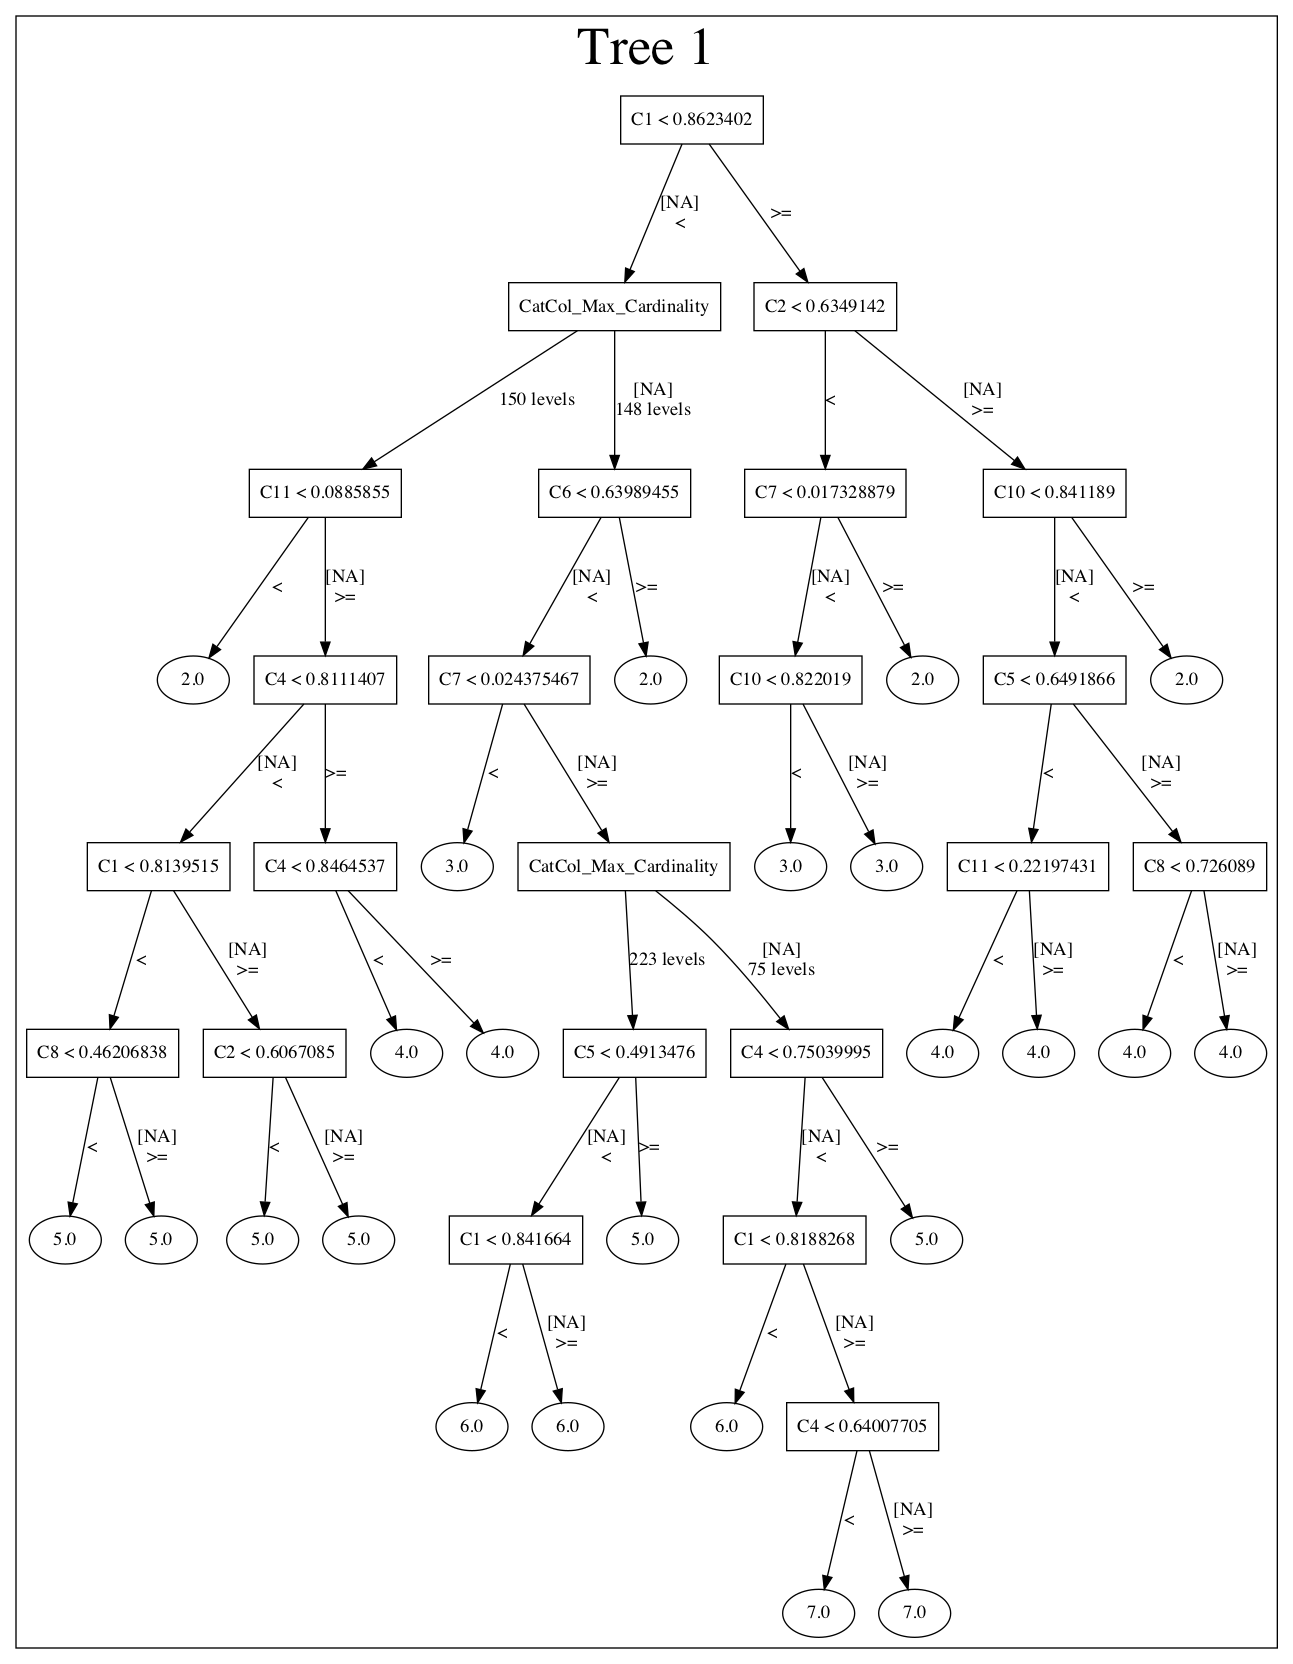

In [21]:
tree_num = 1
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

## Determine the frequency of features for splitting in trees

In [22]:
list_features = []

for i in range(10):
    t = H2OTree(model1, i)
    list_features.extend(t.features)

s_model1 = pd.Series(list_features)

In [23]:
list_features = []

for i in range(10):
    t = H2OTree(model2, i)
    list_features.extend(t.features)

s_model2 = pd.Series(list_features)

In [24]:
list_features = []

for i in range(10):
    t = H2OTree(model3, i)
    list_features.extend(t.features)

s_model3 = pd.Series(list_features)

## How often is the categorical column used in comparison to other features?
Number of times feature was used in all 10 trees

In [25]:
#Model 1:
# CatCol cardinality = 10
s_model1.value_counts()

C4        29
C7        26
C10       25
C12       23
C11       22
C2        22
C3        21
C9        21
CatCol    20
C1        20
C6        18
C5        17
C8        11
dtype: int64

In [26]:
#Model 2:
# CatCol cardinality = 10
# CatCol_with_Numbers, cardinality = 19
s_model2.value_counts()

C9                 30
CatCol_with_Num    29
C3                 26
C4                 25
CatCol             23
C8                 23
C7                 21
C5                 20
C1                 19
C12                17
C11                17
C6                 16
C10                15
C2                 15
dtype: int64

In [27]:
#Model 3:
# CatCol_Max, has maximum cardinality (every row is unique) = 298
s_model3.value_counts()

C1                        31
C4                        31
C3                        29
C11                       29
CatCol_Max_Cardinality    26
C8                        24
C7                        20
C2                        20
C10                       19
C6                        18
C5                        18
C12                       16
C9                        16
dtype: int64

#### We see that the categorical columns are occurring at about the same frequency

# Explore using One-Hot Encoding
#### By default, categorical encodings are using 'enum' for isolation forest. How would the behavior change if we use one-hot encodings instead?

### Model 4 - One-Hot encoded with two cat columns: 
    - CatCol cardinality = 10
    - CatCol_with_Numbers, cardinality = 19
This is essentially model2 but with one-hot encoding

In [28]:
model4 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10,
                                    categorical_encoding = 'one_hot_explicit' #NEW argument added
                                    )
model4.train(training_frame=train)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [29]:
model4.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


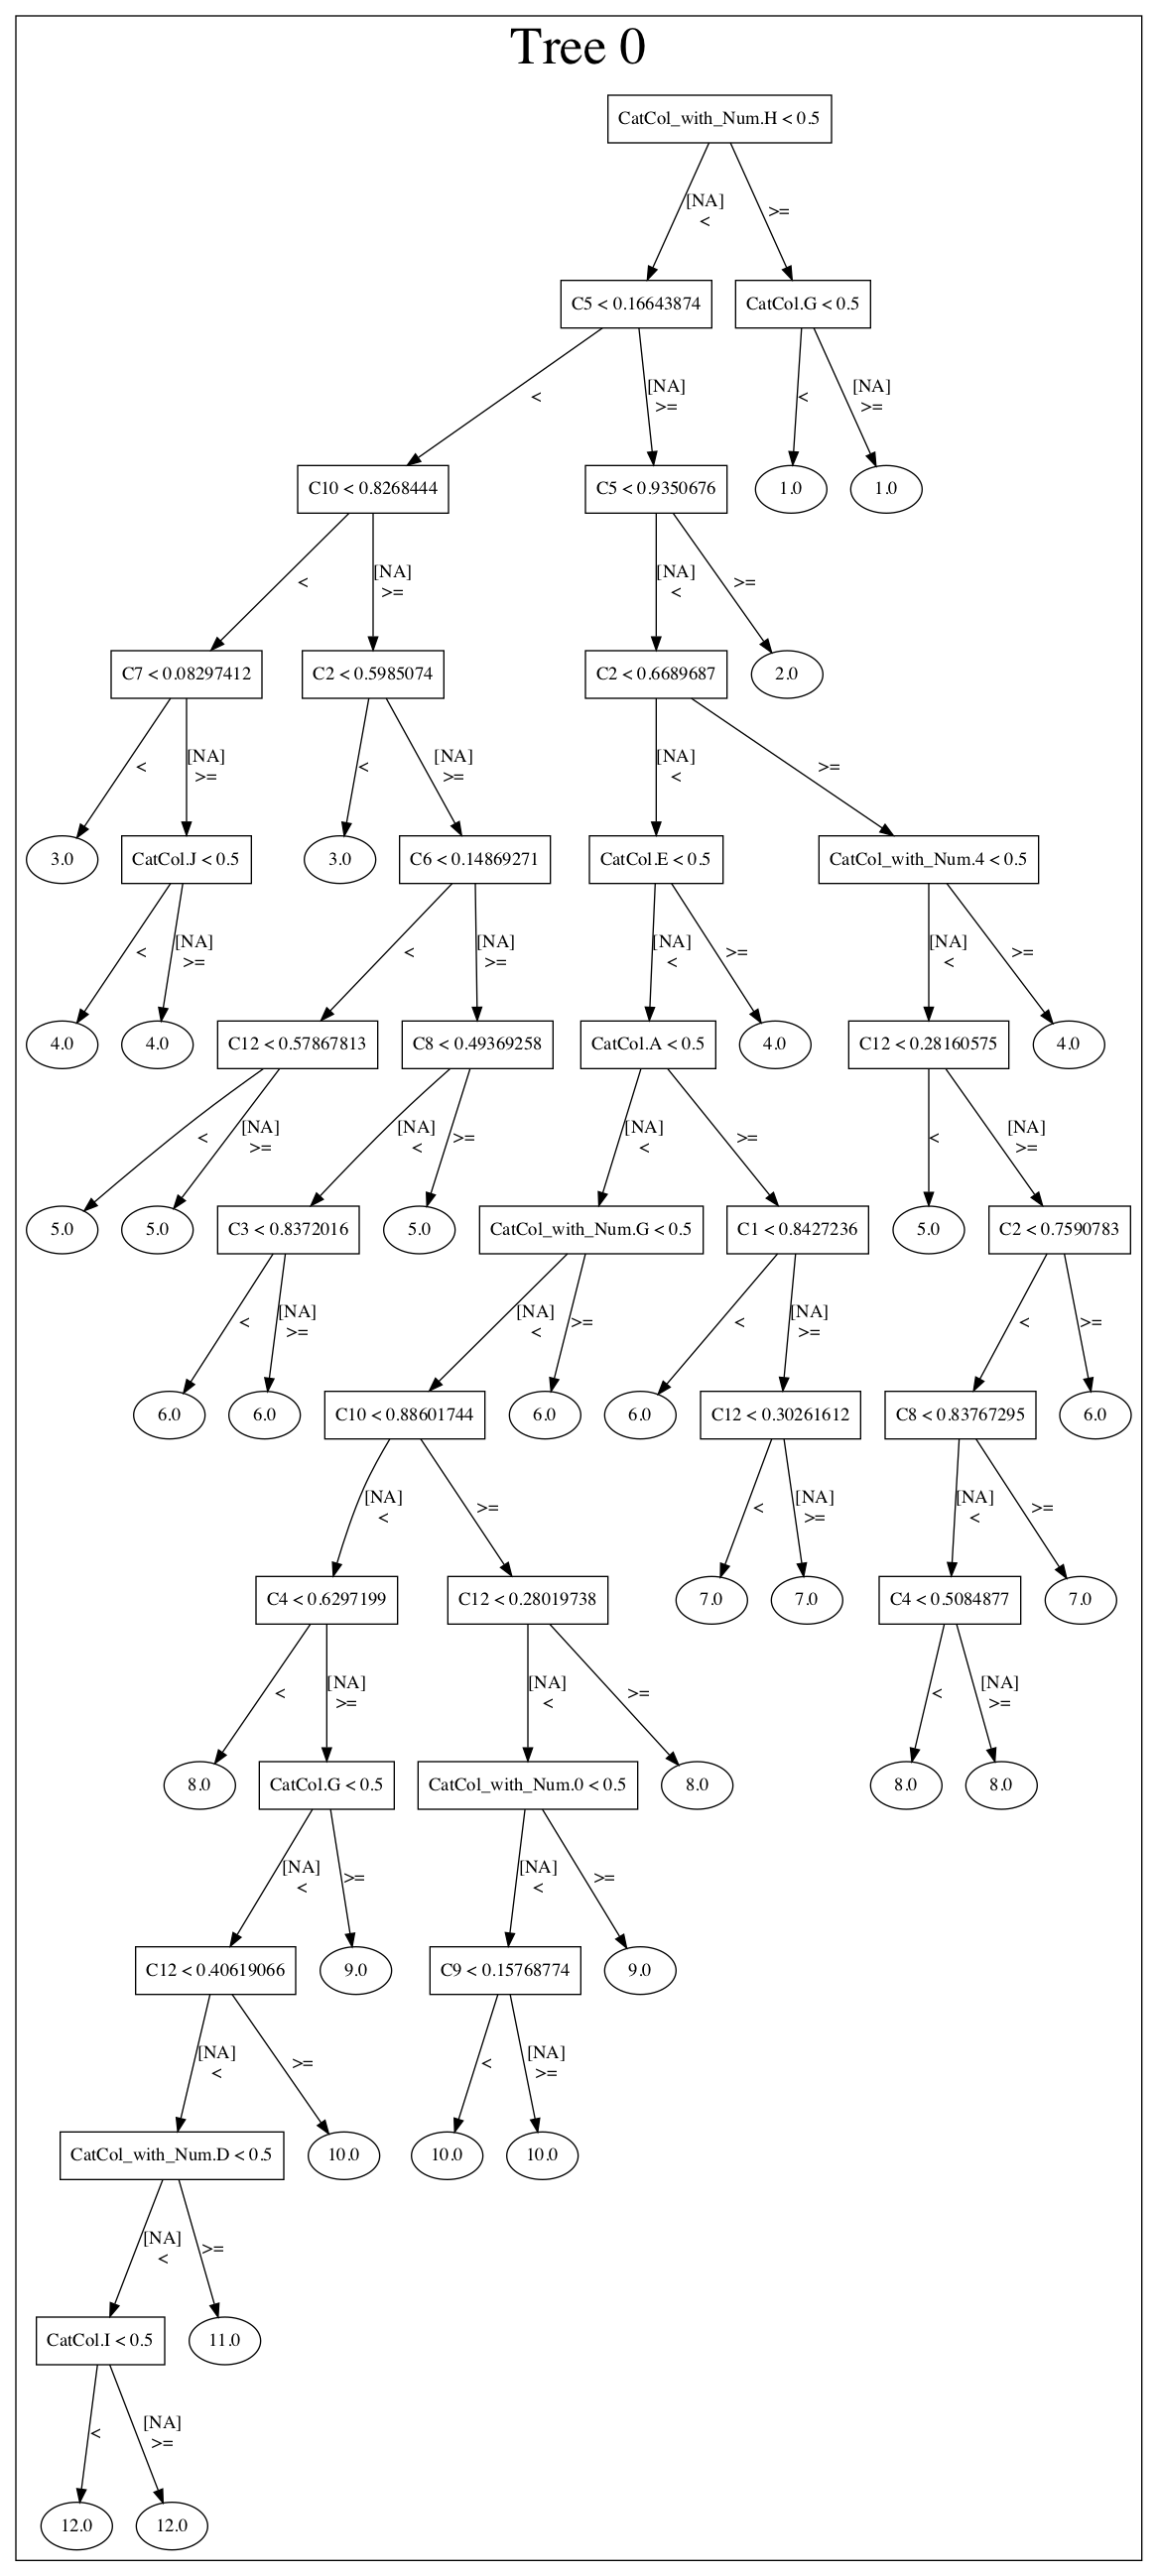

In [30]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

In [31]:
list_features = []

for i in range(10):
    t = H2OTree(model4, i)
    list_features.extend(t.features)

s_model4 = pd.Series(list_features)

#Replace all one-hot encoded Cat columns to original names
s_model4.loc[s_model4.str.contains("CatCol.").fillna(False) 
             & ~s_model4.str.contains("CatCol_with_Num.").fillna(False)] = "CatCol"
s_model4.loc[s_model4.str.contains("CatCol_with_Num.").fillna(False)] = "CatCol_with_Num"

In [32]:
s_model4.value_counts()

CatCol_with_Num    66
CatCol             52
C7                 21
C10                18
C12                17
C4                 17
C2                 17
C8                 13
C6                 12
C9                 12
C1                 12
C5                 12
C11                11
C3                 10
dtype: int64

One-hot encoding made categorical columns (with moderate/low cardinality) much more used compared to other features

## Model 5 - Create One-Hot Encoded (for Max Cardinality) model
Essentially, this is model 3 with one-hot encoding

In [33]:
# Build an Isolation forest model
model5 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10,
                                    categorical_encoding = "one_hot_explicit")
model5.train(training_frame=train_max)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [34]:
model5.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


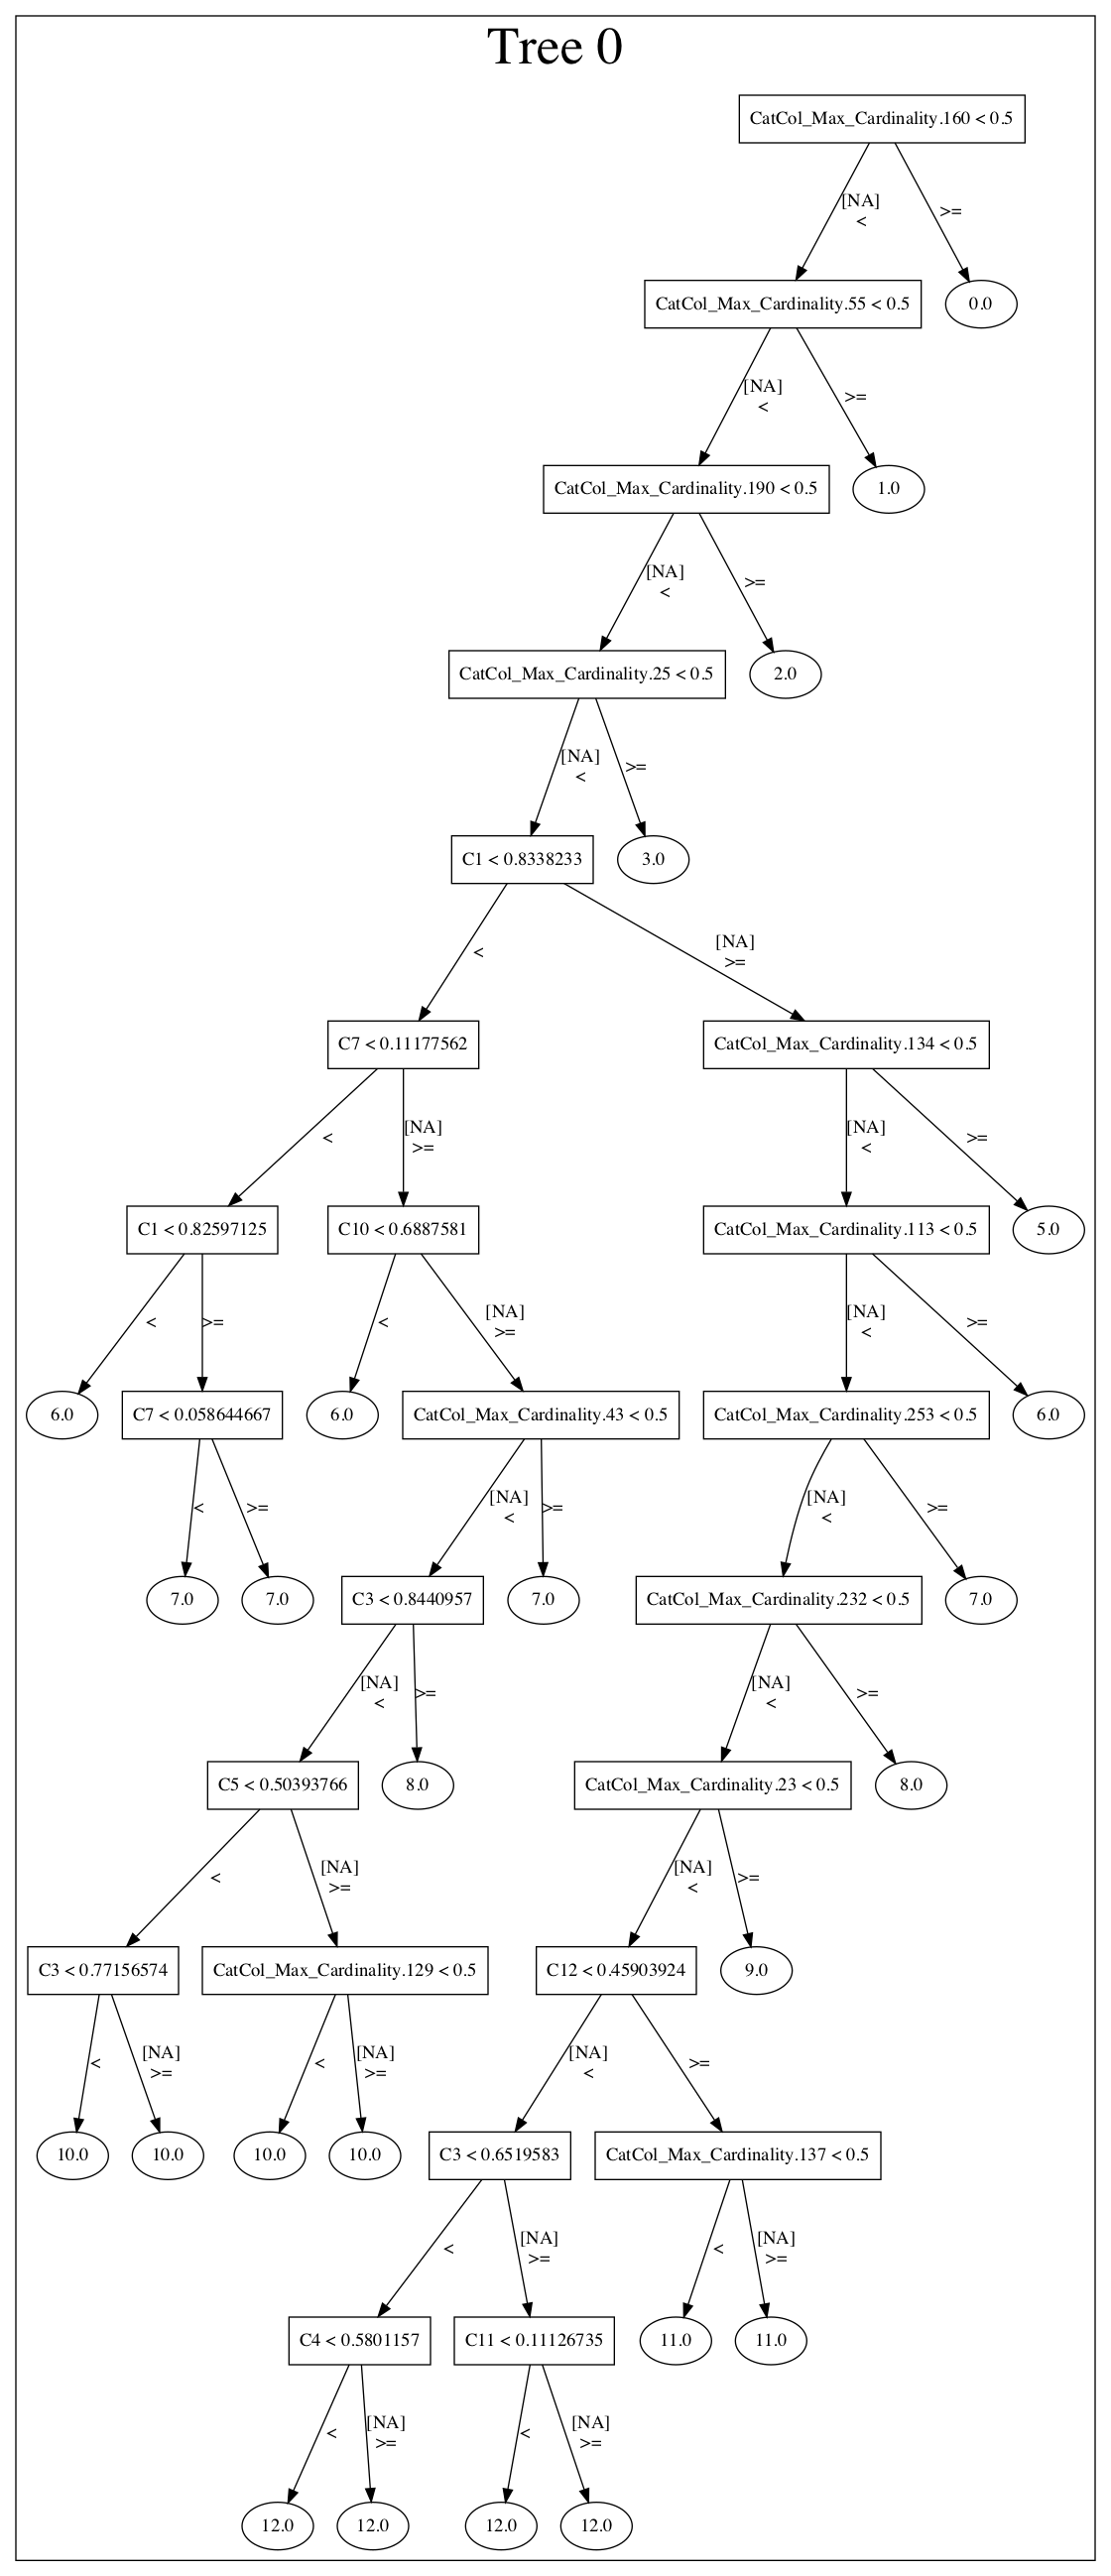

In [35]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

In [36]:
list_features = []

for i in range(10):
    t = H2OTree(model5, i)
    list_features.extend(t.features)

s_model5 = pd.Series(list_features)

#Replace all one-hot encoded Cat columns to original name
s_model5.loc[s_model5.str.contains("CatCol_Max_Cardinality.").fillna(False)] = "CatCol_Max_Cardinality"

In [37]:
#Model 5 with categorical_encoding = "one_hot_explicit"
# CatCol_Max , has maximum cardinality (every row is unique) = 298
s_model5.value_counts()

CatCol_Max_Cardinality    114
C2                         21
C7                         18
C12                        15
C11                        15
C10                        14
C1                         14
C9                         14
C3                         13
C5                         13
C4                         11
C6                         10
C8                          7
dtype: int64

One-hot encoding made categorical columns (for high cardinality) made the feature greatly used. This is due to the nature of one-hot encoding creating N new features (where N is the cardinality value) which increases the chance of that column being randomly selected by IF

## Conclusion
- When default categorical_encoding is used ('enum') in Isolation Forest, categorical columns are randomly selected at about the same frequency as other features (e.g. numeric features)
- If categorical columns have one-hot encodings, their frequency of being used for splits is significantly increased and become dominantly used. The higher the cardinality, the more frequently they will be used.

In [38]:
#Shutdown h2o cluster
h2o.cluster().shutdown()

H2O session _sid_a2b4 closed.
